In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import collections
import random

from typing import Any, Dict, List, Tuple, Union
from pathlib import Path

from recommend.utils import PROJ_ROOT

# Utility functions

In [40]:
def creators2list(creators : str, top_n_actors : int = 3) -> List[str]:
    """Returns a list of `top_n_actors`, director, and a composer."""
    result = []
    
    if 'Hrají' in creators:
        result = creators['Hrají'][:top_n_actors]
        result = list(map(lambda x: x[1], result))

    if 'Režie' in creators:
        result += [creators['Režie'][0][1]]
    if 'Hudba' in creators:
        result += [creators['Hudba'][0][1]]
    return result


def analyse_freq(list_of_lists : List[List[Any]]) -> List[Tuple[Any, int]]:
    """
    Counts occurences of items in a list of lists
    and returns them in descending order as tuples <item, count>."""

    flat_list = [item for sublist in list_of_lists for item in sublist]
    counter = collections.Counter(flat_list)
    return counter.most_common(len(counter))


def get_value(df : pd.DataFrame, movie_id : str, col : str) -> Any:
    """Retrieves a value in a cell specified by `col` for movie with ID `movie_id`"""
    return df.loc[df['movie_id'] == m_id][col].values[0]

def ids2df(ids : List[str], df : pd.DataFrame) -> pd.DataFrame:
    """Converts list of movie_ids to a dataframe while preserving order."""
    # faster but does not preserve order
    #mask = df['movie_id'].isin(ids)
    #return df.loc[mask]

    df_list = []
    for _id in ids:
        df_list.append(df[df['movie_id'] == _id])
    return pd.concat(df_list)

### Czech stemmer

In [3]:
#! /usr/bin/env python3.1
''' Czech stemmer
Copyright © 2010 Luís Gomes <luismsgomes@gmail.com>.

Ported from the Java implementation available at:
    http://members.unine.ch/jacques.savoy/clef/index.html

'''
import re
import sys



def cz_stem(word, aggressive=False):
    if not re.match("^\\w+$", word):
        return word
    if not word.islower() and not word.istitle() and not word.isupper():
        #print("warning: skipping word with mixed case: {}".format(word),
              #file=sys.stderr)
        return word
    s = word.lower() # all our pattern matching is done in lowercase
    s = _remove_case(s)
    s = _remove_possessives(s)
    if aggressive:
        s = _remove_comparative(s)
        s = _remove_diminutive(s)
        s = _remove_augmentative(s)
        s = _remove_derivational(s)
    if word.isupper():
        return s.upper()
    if word.istitle():
        return s.title()
    return s

def _remove_case(word):
    if len(word) > 7 and word.endswith("atech"):
        return word[:-5]
    if len(word) > 6:
        if word.endswith("ětem"):
            return _palatalise(word[:-3])
        if word.endswith("atům"):
            return word[:-4]
    if len(word) > 5:
        if word[-3:] in {"ech", "ich", "ích", "ého", "ěmi", "emi", "ému",
                         "ete", "eti", "iho", "ího", "ími", "imu"}:
            return _palatalise(word[:-2])
        if word[-3:] in {"ách", "ata", "aty", "ých", "ama", "ami",
                         "ové", "ovi", "ými"}:
            return word[:-3]
    if len(word) > 4:
        if word.endswith("em"):
            return _palatalise(word[:-1])
        if word[-2:] in {"es", "ém", "ím"}:
            return _palatalise(word[:-2])
        if word[-2:] in {"ům", "at", "ám", "os", "us", "ým", "mi", "ou"}:
            return word[:-2]
    if len(word) > 3:
        if word[-1] in "eiíě":
            return _palatalise(word)
        if word[-1] in "uyůaoáéý":
            return word[:-1]
    return word

def _remove_possessives(word):
    if len(word) > 5:
        if word[-2:] in {"ov", "ův"}:
            return word[:-2]
        if word.endswith("in"):
            return _palatalise(word[:-1])
    return word

def _remove_comparative(word):
    if len(word) > 5:
        if word[-3:] in {"ejš", "ějš"}:
            return _palatalise(word[:-2])
    return word

def _remove_diminutive(word):
    if len(word) > 7 and word.endswith("oušek"):
        return word[:-5]
    if len(word) > 6:
        if word[-4:] in {"eček", "éček", "iček", "íček", "enek", "ének",
                         "inek", "ínek"}:
            return _palatalise(word[:-3])
        if word[-4:] in {"áček", "aček", "oček", "uček", "anek", "onek",
                         "unek", "ánek"}:
            return _palatalise(word[:-4])
    if len(word) > 5:
        if word[-3:] in {"ečk", "éčk", "ičk", "íčk", "enk", "énk",
                         "ink", "ínk"}:
            return _palatalise(word[:-3])
        if word[-3:] in {"áčk", "ačk", "očk", "učk", "ank", "onk",
                         "unk", "átk", "ánk", "ušk"}:
            return word[:-3]
    if len(word) > 4:
        if word[-2:] in {"ek", "ék", "ík", "ik"}:
            return _palatalise(word[:-1])
        if word[-2:] in {"ák", "ak", "ok", "uk"}:
            return word[:-1]
    if len(word) > 3 and word[-1] == "k":
        return word[:-1]
    return word

def _remove_augmentative(word):
    if len(word) > 6 and word.endswith("ajzn"):
        return word[:-4]
    if len(word) > 5 and word[-3:] in {"izn", "isk"}:
        return _palatalise(word[:-2])
    if len(word) > 4 and word.endswith("ák"):
        return word[:-2]
    return word

def _remove_derivational(word):
    if len(word) > 8 and word.endswith("obinec"):
        return word[:-6]
    if len(word) > 7:
        if word.endswith("ionář"):
            return _palatalise(word[:-4])
        if word[-5:] in {"ovisk", "ovstv", "ovišt", "ovník"}:
            return word[:-5]
    if len(word) > 6:
        if word[-4:] in {"ásek", "loun", "nost", "teln", "ovec", "ovík",
                         "ovtv", "ovin", "štin"}:
            return word[:-4]
        if word[-4:] in {"enic", "inec", "itel"}:
            return _palatalise(word[:-3])
    if len(word) > 5:
        if word.endswith("árn"):
            return word[:-3]
        if word[-3:] in {"ěnk", "ián", "ist", "isk", "išt", "itb", "írn"}:
            return _palatalise(word[:-2])
        if word[-3:] in {"och", "ost", "ovn", "oun", "out", "ouš",
                         "ušk", "kyn", "čan", "kář", "néř", "ník",
                         "ctv", "stv"}:
            return word[:-3]
    if len(word) > 4:
        if word[-2:] in {"áč", "ač", "án", "an", "ář", "as"}:
            return word[:-2]
        if word[-2:] in {"ec", "en", "ěn", "éř", "íř", "ic", "in", "ín",
                         "it", "iv"}:
            return _palatalise(word[:-1])
        if word[-2:] in {"ob", "ot", "ov", "oň", "ul", "yn", "čk", "čn",
                         "dl", "nk", "tv", "tk", "vk"}:
            return word[:-2]
    if len(word) > 3 and word[-1] in "cčklnt":
        return word[:-1]
    return word

def _palatalise(word):
    if word[-2:] in {"ci", "ce", "či", "če"}:
        return word[:-2] + "k"

    if word[-2:] in {"zi", "ze", "ži", "že"}:
        return word[:-2] + "h"

    if word[-3:] in {"čtě", "čti", "čtí"}:
        return word[:-3] + "ck"

    if word[-3:] in {"ště", "šti", "ští"}:
        return word[:-3] + "sk"
    return word[:-1]

"""
if __name__ == '__main__':
    if len(sys.argv) != 2 or sys.argv[1] not in ("light", "aggressive"):
        sys.exit("usage: {} light|aggressive".format(sys.argv[0]))
    aggressive = sys.argv[1] == "aggressive"
    for line in sys.stdin:
        print(*[cz_stem(word, aggressive=aggressive)
                for word in line.split()])
"""
pass

# Load datasets

In [4]:
movies = pd.read_pickle(PROJ_ROOT / 'data' / 'movies.pkl')
ratings = pd.read_pickle(PROJ_ROOT / 'data' / 'ratings.pkl')

# Drop irrelevant columns
movies = movies.drop(columns=['kind', 'length', 'poster', 'foreign_titles'])

# Convert creators column to list of creators
movies['creators'] = movies['creators'].apply(creators2list)
#movies.reset_index(inplace=True) # causes trouble with join

display(movies.head(3))
ratings.head(3)

,title,description,genres,countries,year,creators
movie_id,,,,,,
230421-houbicky,Houbičky,"Partička amerických teenagerů, která si vyrazi...","[Horor, Thriller]","[Irsko, Velká Británie, Dánsko]",2007,"[Lindsey Haun, Jack Huston, Max Kasch, Paddy B..."
10789-prvni-liga,První liga,V nejvyšší lize získávají hráči baseballu boha...,"[Komedie, Sportovní]",[USA],1989,"[Tom Berenger, Charlie Sheen, Corbin Bernsen, ..."
235032-yes-man,Yes Man,"Carl Allen je zatrpklý bankovní úředník, který...","[Komedie, Romantický]",[USA],2008,"[Jim Carrey, Zooey Deschanel, Bradley Cooper, ..."


,username,movie_id,stars,date,comment
0,kinghome,230421-houbicky,5.0,2011-11-13,Hodnocení některých šašků tady opravdu necháp...
1,SimonShot,230421-houbicky,5.0,2012-12-19,Tento snímek je zajímavý už jenom tím že se n...
2,blackend,230421-houbicky,5.0,2010-09-04,Pohoda a vzhledem k dobré atmosféře a nízkému...


In [151]:
# get mean rating of each film 
avg_ratings = ratings[['movie_id', 'stars']].groupby(['movie_id']).mean()
avg_ratings.rename(columns={'stars': 'avg_stars'}, inplace=True)

# get rating count of each film
count_ratings = ratings[['movie_id', 'stars']].groupby('movie_id').count()
count_ratings.rename(columns={'stars': 'num_ratings'}, inplace=True)
count_ratings

# join with the movies database
movie_db = movies.join(avg_ratings).join(count_ratings).sort_values(by='num_ratings')
movie_db = movie_db.reset_index()
movie_db



# Compute Bayesian Average Rating Score -> 4.6* movie with many reviews > 5.0* movie with few reviews

def compute_bayes_avg(item_rating_avg : float, item_rating_count : int, M, C) -> float:
    """Computes Bayesian average rating for an item"""
    return (item_rating_avg * item_rating_count + C*M) / (item_rating_count + C)

# arithmetic average of all movies
M = np.sum(movie_db.avg_stars * movie_db.num_ratings) / np.sum(movie_db.num_ratings)     
# confidence number (~25% percentile)
C = movie_db.num_ratings.quantile(0.25)

movie_db['bayes_avg_rating'] = compute_bayes_avg(movie_db.avg_stars, movie_db.num_ratings, M, C)

movie_db

,movie_id,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
0,75613-hercule-poirot_498504-serie-9,Hercule Poirot,Malý belgický detektiv Hercule Poirot (David S...,"[Krimi, Drama, Mysteriózní, Thriller]",[Velká Británie],(1989–2013),"[David Suchet, Hugh Fraser, Philip Jackson, Ed...",5.000000,1,3.501384
1,613789-obeti,Oběti,Na televizní obrazovku se vrací cyklus o lide...,[Drama],[Česko],(1999–2008),"[Zbyněk Fric, Karel Zima, Libor Žídek, Petr Sl...",5.000000,1,3.501384
2,75613-hercule-poirot_498507-serie-12,Hercule Poirot,Malý belgický detektiv Hercule Poirot (David S...,"[Krimi, Drama, Mysteriózní, Thriller]",[Velká Británie],(1989–2013),"[David Suchet, Hugh Fraser, Philip Jackson, Ed...",4.500000,2,3.506088
3,350930-krtek,Krtek,,"[Animovaný, Dobrodružný]","[Česko, Finsko]",2011,"[Zdeněk Miler, Wiliam Bukový]",4.500000,2,3.506088
4,33863-bajaja,Bajaja,Jiří Trnka natočil v roce 1950 volně podle poh...,"[Animovaný, Loutkový, Pohádka]",[Československo],1950,"[Jiří Trnka, Václav Trojan]",4.285714,14,3.581740
...,...,...,...,...,...,...,...,...,...,...
8669,232938-hobit-neocekavana-cesta,Hobit: Neočekávaná cesta,Film sleduje cestu hlavní postavy Bilbo Pytlík...,"[Dobrodružný, Fantasy]","[USA, Nový Zéland]",2012,"[Martin Freeman, Ian McKellen, Richard Armitag...",3.953150,3159,3.938292
8670,227786-interstellar,Interstellar,Příběh se odehrává v nepříliš vzdálené budoucn...,"[Sci-Fi, Dobrodružný, Drama]","[USA, Velká Británie, Kanada]",2014,"[Matthew McConaughey, Anne Hathaway, Jessica C...",4.072779,3174,4.054193
8671,223734-temny-rytir,Temný rytíř,Další Batmanovo dobrodružství začíná. Jeho pro...,"[Akční, Drama, Krimi, Thriller]","[USA, Velká Británie]",2008,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",4.559151,3770,4.530368
8672,254156-pocatek,Počátek,Dom Cobb (Leonardo DiCaprio) je velmi zkušený ...,"[Akční, Sci-Fi, Thriller, Mysteriózní, Dobrodr...","[USA, Velká Británie]",2010,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elli...",4.368000,4000,4.345674



# Recommendation Systems
---
## Base class

In [56]:
import abc

class RecSysBase(abc.ABC):
    """
    Recommendation System Base class.
    
    The system should store a database of available movies.
    
    """
    def __init__(self, movies_df : pd.DataFrame):
        self.movies_df = movies_df

    @abc.abstractmethod
    def recommend(self, user_history : List[str], n : int = 10, return_df : bool = False) -> Union[List[str], pd.DataFrame]:
        """
        Generates recommendations based on user's history of rated movies.
        
        Parameters
        ----------
        user_history : List[str]
            A list of movie ids a user has rated so far.
            
        n : int
            The number of recommendations to return.
        
        Returns
        -------
        Union[List[str], pd.DataFrame]
            By default returns a list of strings representeing movie ids.
            If `return_df` is set to True then a pandas dataframe.
        """
        # TODO: do we need `user_history` as List?
        # use List if: some systems use the order of items (e.g. preference of recent movies)
        # use Set if: we dont care at all about 
        pass

    def get_candidate_movies(self, user_history : List[str]) -> pd.DataFrame:
        """Returns a list of candidates by filtering movies a user has already seen."""
        df = pd.concat([self.movies_df, self._ids2df(user_history, preserve_order=False)])
        # convert to str because drop_duplicates does not work on dfs containing structures
        return df.loc[df.astype(str).drop_duplicates(keep=False).index]

    def _ids2df(self, movie_ids : List[str], preserve_order : bool = True) -> pd.DataFrame:
        """For a list of movie ids returns a dataframe compatible with `self.movies_df`"""        
        if not preserve_order or len(movie_ids) == 0:
            # faster variant but sorted as in self.movies_df 
            mask = self.movies_df['movie_id'].isin(movie_ids)
            return self.movies_df.loc[mask]

        df_list = []
        for mid in movie_ids:
            df_list.append(self.movies_df[self.movies_df['movie_id'] == mid])
        return pd.concat(df_list)

    
    def get_description_with_id(self, movie_id : str) -> str:
        """Returns description for movie with provided ID"""
        #TODO: handle case when no such movie exists
        return self.movies_df.loc[self.movies_df['movie_id'] == movie_id].description.values[0]
    


## Random recommendations

In [61]:
import random

class RandomRS(RecSysBase):
    """
    System that recommends movies randomly.
    """
    def __init__(self, movies_df : pd.DataFrame):
        super(RandomRS, self).__init__(movies_df)

    def recommend(self, user_history : List[str], n : int = 10, return_df : bool = False) -> List[str]:
        """
        Recommends n random movies.
        Movies from `user_history` do not appear in the recommendations.
        """
        recommendations = self.get_candidate_movies(user_history).sample(n)
        return recommendations if return_df else recommendations.movie_id
    


In [65]:
rnd_rs = RandomRS(movie_db)

rnd_rs.recommend([], 3, return_df=True)

,movie_id,title,description,genres,countries,year,creators,avg_stars,num_ratings
4785,11708-jerry-maguire,Jerry Maguire,"Tom Cruise září jako Jerry Maguire, sportovní ...","[Komedie, Drama, Romantický, Sportovní]",[USA],1996,"[Tom Cruise, Cuba Gooding Jr., Renée Zellweger...",3.383178,214
4512,134922-pisen-lasky-samotarky,Píseň lásky samotářky,"Když se Pursy (Scarlett Johansson) dozví, že j...",[Drama],[USA],2004,"[John Travolta, Scarlett Johansson, Gabriel Ma...",3.868020,197
4832,29220-delikatesy,Delikatesy,Poetická černá komedie DELIKATESY je dlouho př...,"[Komedie, Krimi]",[Francie],1991,"[Dominique Pinon, Marie-Laure Dougnac, Jean-Cl...",3.720183,218


## Recommendation based on movie popularity

In [160]:

class TopNRS(RecSysBase):
    """
    System recommends top n most popular movies a user has not rated yet.
    """
    def __init__(self, movies_df : pd.DataFrame, by_column : str):
        super(TopNRS, self).__init__(movies_df)
        self.by_column = by_column
        
    
    def set_by_column(self, new_column_name : str):
        self.by_column = new_column_name

    def recommend(self, user_history : List[str], n : int = 10, return_df : bool = False) -> List[str]:
        """
        Recommends top n movies (a user has not yet seen) which are sorted by a selected column.
        """
        recommendations = self.get_candidate_movies(user_history)\
                                .sort_values(by=self.by_column, ascending=False)\
                                .head(n)
        return recommendations if return_df else recommendations.movie_id[0]
    

In [161]:
history = ['228329-avatar']

rs_num_ratings = TopNRS(movie_db, 'num_ratings')

rs_num_ratings.recommend(history, 3, return_df=True)

,movie_id,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
8672,254156-pocatek,Počátek,Dom Cobb (Leonardo DiCaprio) je velmi zkušený ...,"[Akční, Sci-Fi, Thriller, Mysteriózní, Dobrodr...","[USA, Velká Británie]",2010,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elli...",4.368000,4000,4.345674
8671,223734-temny-rytir,Temný rytíř,Další Batmanovo dobrodružství začíná. Jeho pro...,"[Akční, Drama, Krimi, Thriller]","[USA, Velká Británie]",2008,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",4.559151,3770,4.530368
8670,227786-interstellar,Interstellar,Příběh se odehrává v nepříliš vzdálené budoucn...,"[Sci-Fi, Dobrodružný, Drama]","[USA, Velká Británie, Kanada]",2014,"[Matthew McConaughey, Anne Hathaway, Jessica C...",4.072779,3174,4.054193


In [164]:
rs_bayes_avg = TopNRS(movie_db, 'bayes_avg_rating')
rs_bayes_avg.recommend([], 15, return_df=True)

,movie_id,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
8667,2294-vykoupeni-z-veznice-shawshank,Vykoupení z věznice Shawshank,Andy Dufresne (Tim Robbins) je mladý a úspěšný...,"[Drama, Krimi]",[USA],1994,"[Tim Robbins, Morgan Freeman, Bob Gunton, Fran...",4.766101,3121,4.724851
8466,821-s-certy-nejsou-zerty,S čerty nejsou žerty,"V jednom malém knížectví žijí všichni, kdo ve ...","[Pohádka, Komedie]",[Československo],1984,"[Vladimír Dlouhý, Ondřej Vetchý, Karel Heřmáne...",4.802603,1383,4.710589
8595,1248-terminator-2-den-zuctovani,Terminátor 2: Den zúčtování,"V budoucnosti probíhá válka lidí se stroji, kt...","[Akční, Sci-Fi, Thriller]","[USA, Francie]",1991,"[Arnold Schwarzenegger, Linda Hamilton, Edward...",4.776496,1821,4.706829
8663,10135-forrest-gump,Forrest Gump,"“Pro hlupáka každý hloupý,"" říká Forrest Gump ...","[Drama, Komedie, Romantický]",[USA],1994,"[Tom Hanks, Robin Wright, Gary Sinise, Robert ...",4.732861,2961,4.690586
8546,6178-dvanact-rozhnevanych-muzu,Dvanáct rozhněvaných mužů,Dvanáct porotců má jednomyslně rozhodnout o vi...,"[Drama, Krimi]",[USA],1957,"[Martin Balsam, John Fiedler, Lee J. Cobb, Sid...",4.767413,1608,4.689629
8331,70341-bratrstvo-neohrozenych,Bratrstvo neohrožených,představuje zásadní počin v historii HBO i tel...,"[Válečný, Drama, Historický]","[Velká Británie, USA]",2001,"[Damian Lewis, Scott Grimes, Ron Livingston, D...",4.769889,1169,4.665079
8628,9499-matrix,The Matrix,"Za vším hledej Matrix. Zdál se vám někdy sen, ...","[Akční, Sci-Fi]",[USA],1999,"[Keanu Reeves, Laurence Fishburne, Carrie-Anne...",4.685115,2096,4.628475
8636,2671-sedm,Sedm,Zkušený detektiv Somerset má sedm dnů do důcho...,"[Thriller, Krimi, Mysteriózní, Psychologický, ...",[USA],1995,"[Brad Pitt, Morgan Freeman, Gwyneth Paltrow, D...",4.679161,2241,4.626288
8049,8641-indiana-jones-a-posledni-krizova-vyprava,Indiana Jones a Poslední křížová výprava,Píše se rok 1938 a Indiana Jones působí jako u...,"[Dobrodružný, Akční, Fantasy]",[USA],1989,"[Harrison Ford, Sean Connery, Denholm Elliott,...",4.724750,901,4.596662
8376,6642-smrtonosna-past,Smrtonosná past,Policista John McClane přilétá na Vánoce do Lo...,"[Akční, Thriller]",[USA],1988,"[Bruce Willis, Bonnie Bedelia, Alan Rickman, J...",4.690244,1230,4.596436


# Gensim models: TFIDF, LSI

In [139]:

class GensimModelWrapper(RecSysBase):
    """
    Base class for gensim based models.
    Implements methods for document preprocessing.
    """
    def __init__(self, movies_df : pd.DataFrame):
        super(GensimModelWrapper, self).__init__(movies_df)
    
    @abc.abstractmethod
    def recommend(self, user_history : List[str], n : int = 10, return_df : bool = False) -> List[str]:
        ...
    
    @classmethod
    def _document_to_tokens(cls, document: str) -> List[str]:
        """
        Filters stop words and applies stemming on the given string.

        Parameters
        ----------
        text : str
            A simple string containing text to preprocess.
        """
        tokens = word_tokenize(document.lower(), language='czech')
        filtered = [w.strip(",.:'?!()[]{}<>_") for w in document.split() if w not in set(stop_words.get_stop_words('czech'))]
        res = [cz_stem(word) for word in filtered]
        return res
    
    @classmethod
    def _document_to_bag_of_words(cls, document: str) -> List[Tuple[int, int]]:
        return cls.DICTIONARY.doc2bow(cls._document_to_tokens(document))
    
    @classmethod
    def _tokens_to_bag_of_words(cls, tokens: List[str]) -> List[Tuple[int, int]]:
        return cls.DICTIONARY.doc2bow(tokens)
    

## TF-IDF Model

In [140]:
import stop_words
from nltk.tokenize import word_tokenize
from multiprocessing import get_context, Pool
from gensim.corpora import Dictionary
from gensim.matutils import cossim
from gensim.models import TfidfModel
from gensim.similarities import SparseMatrixSimilarity
from gensim.utils import simple_preprocess
from tqdm import tqdm


class TfidfRS(GensimModelWrapper):
    """
    System recommends unseen movies using TF-IDF
    """
    def __init__(self, movies_df : pd.DataFrame):
        super(TfidfRS, self).__init__(movies_df)
        
        # Document == movie title & description
        documents = list(movies_df.title.astype(str) + ' ' + movies_df.description)
        
        #TODO: can we move the following functionality to GensimModelWrapper??

        # Build Dictionary
        with get_context('fork').Pool(None) as pool:
            doc_tokens = pool.imap(self.__class__._document_to_tokens, documents)
            doc_tokens = tqdm(doc_tokens, desc='Building the dictionary', total=len(documents))
            self.dictionary = Dictionary(doc_tokens)
            self.__class__.DICTIONARY = self.dictionary
        
        # Build TF-IDF model
        with get_context('fork').Pool(None) as pool:
            #doc_bows = pool.imap(self.__class__._tokens_to_bag_of_words, self.__class__.doc_tokens)
            doc_bows = pool.imap(self.__class__._document_to_bag_of_words, documents)
            doc_bows = tqdm(doc_bows, desc='Building the TF-IDF model', total=len(documents))
            self.tfidf_model = TfidfModel(doc_bows)
            self.__class__.TFIDF_MODEL = self.tfidf_model

        # Build the index
        with get_context('fork').Pool(None) as pool:    
            #doc_vectors = pool.imap(self.__class__._bow_to_tfidf_vector, self.doc_bows)
            doc_vectors = pool.imap(self.__class__._document_to_tfidf_vector, documents)
            doc_vectors = tqdm(doc_vectors, desc='Building the TF-IDF index', total=len(documents))
            self.index = SparseMatrixSimilarity(doc_vectors, num_docs=len(documents), num_terms=len(self.dictionary))
            
        del self.__class__.DICTIONARY
        del self.__class__.TFIDF_MODEL 

        self.index_to_movie_id = dict(enumerate(self.movies_df.movie_id.to_list()))

    
    def recommend(self, user_history : List[str], n : int = 10, return_df : bool = False) -> List[str]:
        """Recommends unseen movies using tfidf vectors and cosine similarity.
        
        TODO: Is it better to yield movies one by one or return a list / DF?
        TODO: solve because `n` and `return_df` are currently not used
        
        Parameters
        ----------
        user_history : List[str]
            A list of movie IDs
        """
        # Take last k movies, join them into a single description and create a query.
        k = 50 # TODO: should this be a configurable parameter? should it be tuned?
        last_k_movies = user_history[-k:]
        query = ' '.join([self.get_description_with_id(mid) for mid in last_k_movies])
        
        self.__class__.DICTIONARY = self.dictionary
        self.__class__.TFIDF_MODEL = self.tfidf_model

        query_vector = self.__class__._document_to_tfidf_vector(query)
        similarities = enumerate(self.index[query_vector])
        similarities = sorted(similarities, key=lambda item: item[1], reverse=True)

        result_ids = []
        for idx, sim in similarities:
            movie_id = self.index_to_movie_id[idx]
            if movie_id not in user_history:
                yield movie_id, sim
                #result_ids.append(movie_id)
        
        del self.__class__.DICTIONARY
        del self.__class__.TFIDF_MODEL
        
#        return self._ids2df(result_ids) if return_df else result_ids

    @classmethod
    def _document_to_tfidf_vector(cls, document: str) -> List[Tuple[int, float]]:
        return cls.TFIDF_MODEL[cls._document_to_bag_of_words(document)]
    
    @classmethod
    def _bow_to_tfidf_vector(cls, bow: List[Tuple[int, int]]) -> List[Tuple[int, float]]:
        return cls.TFIDF_MODEL[bow]

In [141]:
rs_tfidf = TfidfRS(movie_db)

Building the TF-IDF index: 100%|█████████████████████████████████████████████████████████████| 8674/8674 [00:08<00:00, 1025.55it/s]


In [142]:
history = ['1644-kmotr', '1645-kmotr-ii', '9499-matrix', '342231-lego-batman']

for i, (movie_id, sim)  in enumerate(rs_tfidf.recommend(history)):
    print(f'{i+1}. {movie_id} ({sim:.4f})')
    if i == 15: break

1. 1646-kmotr-iii (0.2877)
2. 1643-kmotr-1-2-3 (0.1815)
3. 392898-lego-r-batman-film (0.1460)
4. 9498-matrix-revolutions (0.1383)
5. 266796-liga-spravedlivych-krize-na-dvou-zemich (0.1189)
6. 223734-temny-rytir (0.1188)
7. 8254-spinave-ulice (0.1153)
8. 1069-batman (0.1152)
9. 18798-valachiho-svedectvi (0.1091)
10. 234816-liga-spravedlnosti (0.1056)
11. 6444-nelitostny-souboj (0.1037)
12. 60899-batman-vs-joker (0.1011)
13. 182290-marie-antoinetta (0.1002)
14. 234081-opravnene-vrazdy (0.0995)
15. 319515-batman-navrat-temneho-rytire-cast-2 (0.0981)
16. 8216-batman-navzdy (0.0970)


In [144]:
rec_ids = list(map(lambda x: x[0], rs_tfidf.recommend(history)))[:10]
ids2df(rec_ids, movie_db)

,movie_id,title,description,genres,countries,year,creators,avg_stars,num_ratings,bayes_avg_rating
7675,1646-kmotr-iii,Kmotr III,Člověk financí a politiky. Al Pacino v hlavní ...,"[Drama, Krimi]",[USA],1990,"[Al Pacino, Diane Keaton, Talia Shire, Francis...",4.309144,689,4.201318
2928,1643-kmotr-1-2-3,"Kmotr 1, 2, 3",Původní trilogie KMOTR je zde sestříhána v chr...,"[Krimi, Drama, Thriller]",[USA],1992,"[Marlon Brando, Al Pacino, Robert Duvall, Fran...",4.828125,128,4.226920
6037,392898-lego-r-batman-film,LEGO® Batman film,Batman pokračuje v neúnavné obraně Gotham City...,"[Animovaný, Akční, Dobrodružný, Komedie, Rodin...","[USA, Dánsko]",2017,"[Will Arnett, Jenny Slate, Ralph Fiennes, Chri...",3.538700,323,3.526102
8018,9498-matrix-revolutions,Matrix Revolutions,Ve výbušné závěrečné kapitole trilogie Matrix ...,"[Akční, Sci-Fi]","[USA, Austrálie]",2003,"[Keanu Reeves, Laurence Fishburne, Carrie-Anne...",3.435927,874,3.441355
1971,266796-liga-spravedlivych-krize-na-dvou-zemich,Liga spravedlivých: Krize na dvou Zemích,Alternativní vesmírné dobrodružství navždy změ...,"[Animovaný, Akční, Sci-Fi]",[USA],2010,"[Mark Harmon, Nolan North, William Baldwin, La...",3.818182,99,3.648499
8671,223734-temny-rytir,Temný rytíř,Další Batmanovo dobrodružství začíná. Jeho pro...,"[Akční, Drama, Krimi, Thriller]","[USA, Velká Británie]",2008,"[Christian Bale, Heath Ledger, Aaron Eckhart, ...",4.559151,3770,4.530368
5386,8254-spinave-ulice,Špinavé ulice,"Svoje hříchy neodčiníš v kostele, ale na ulici...","[Drama, Krimi, Thriller]",[USA],1973,"[Robert De Niro, Harvey Keitel, David Proval, ...",3.434615,260,3.449575
7940,1069-batman,Batman,"V Gothamu bojuje proti zločinu nejen policie, ...","[Akční, Krimi, Thriller]","[USA, Velká Británie]",1989,"[Michael Keaton, Jack Nicholson, Kim Basinger,...",4.173755,823,4.096705
1390,18798-valachiho-svedectvi,Valachiho svědectví,Gangster Joseph „Joe“ Valachi (Charles Bronson...,"[Krimi, Drama]","[Francie, Itálie]",1972,"[Charles Bronson, Lino Ventura, Jill Ireland, ...",3.682927,82,3.573362
8126,234816-liga-spravedlnosti,Liga spravedlnosti,Po Supermanově smrti hledají Batman a Wonder W...,"[Akční, Dobrodružný, Fantasy, Sci-Fi]",[USA],2017,"[Ben Affleck, Gal Gadot, Henry Cavill, Zack Sn...",2.746862,956,2.819477


## LSA Model

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [21]:
from gensim.models import LsiModel

# TODO: just copied, not working yet
class LsiRS(GensimModelWrapper):
    def __init__(self, movies_df : pd.DataFrame):
        super(LsiRS, self).__init__(movies_df)
        
        # Document == movie title & description
        documents = list(movies_df.title.astype(str) + ' ' + movies_df.description)
        
        # Build Dictionary
        with get_context('fork').Pool(None) as pool:
            doc_tokens = pool.imap(self.__class__._document_to_tokens, documents)
            doc_tokens = tqdm(doc_tokens, desc='Building the dictionary', total=len(documents))
            self.dictionary = Dictionary(doc_tokens)
            self.__class__.DICTIONARY = self.dictionary
        
        # Build TF-IDF model
        with get_context('fork').Pool(None) as pool:
            #doc_bows = pool.imap(self.__class__._tokens_to_bag_of_words, self.__class__.doc_tokens)
            doc_bows = pool.imap(self.__class__._document_to_bag_of_words, documents)
            doc_bows = tqdm(doc_bows, desc='Building the TF-IDF model', total=len(documents))
            self.lsi_model = LsiModel(doc_bows)
            self.__class__.LSI_MODEL = self.lsi_model

        # Build the index
        with get_context('fork').Pool(None) as pool:    
            #doc_vectors = pool.imap(self.__class__._bow_to_tfidf_vector, self.doc_bows)
            doc_vectors = pool.imap(self.__class__._document_to_tfidf_vector, documents)
            doc_vectors = tqdm(doc_vectors, desc='Building the TF-IDF index', total=len(documents))
            self.index = SparseMatrixSimilarity(doc_vectors, num_docs=len(documents), num_terms=len(self.dictionary))
            
        del self.__class__.DICTIONARY
        del self.__class__.TFIDF_MODEL 

        self.index_to_movie_id = dict(enumerate(self.movies_df.movie_id.to_list()))

    
    def recommend(self, user_history : List[str], n : int = 10, return_df : bool = False) -> List[str]:
        # TODO:
        ...

    @classmethod
    def _document_to_lsi_vector(cls, document: str) -> List[Tuple[int, float]]:
        return cls.LSI_MODEL[cls._document_to_bag_of_words(document)]
    
    @classmethod
    def _bow_to_lsi_vector(cls, bow: List[Tuple[int, int]]) -> List[Tuple[int, float]]:
        return cls.LSI_MODEL[bow]

In [40]:
# Build a Dictionary
documents = movie_db.description.to_list()
doc_tokens = list(map(GensimModelWrapper._document_to_tokens, documents))
#doc_tokens = tqdm(doc_tokens, desc='Building the dictionary', total=len(documents))
dictionary = Dictionary(doc_tokens)

In [41]:
def tokens2bow(dct, tokens):
    return dct.doc2bow(tokens)

corpus_bows = [tokens2bow(dictionary, tokens) for tokens in doc_tokens]
#corpus_bows = tqdm(corpus_bows, desc='Building LSI model', total=len(documents))
lsi_model = LsiModel(corpus_bows, num_topics=200, id2word=dictionary)

In [42]:
lsi_model

---
# Playground

In [150]:
df = pd.DataFrame({
    'movie_id': ['A', 'B', 'C'],
    'avg_stars': [5, 4.8, 4.6],
    'num_ratings': [10, 100, 1000]
})

M = 3.5#np.sum(df.avg_stars * df.num_ratings) / np.sum(df.num_ratings) 
C = 100#df.num_ratings.quantile(0.25)

def compute_bayes_avg(item_rating_avg, item_rating_count, m, c):
    return (item_rating_avg*item_rating_count + c*m) / (item_rating_count + c)

df['bayes_avg'] = compute_bayes_avg(df.avg_stars, df.num_ratings, M,C)
df

,movie_id,avg_stars,num_ratings,bayes_avg
0,A,5.0,10,3.636364
1,B,4.8,100,4.150000
2,C,4.6,1000,4.500000


In [ ]:
df_matrix = movie_db[movie_db['movie_id'].str.contains('matrix')].tail(3)
df_kmotr = movie_db[movie_db['title'].str.contains('Kmotr')].tail(3)
df_nolan = movie_db[movie_db.creators.map(set(['Christopher Nolan']).issubset)].tail(3)

test_df = pd.concat([df_matrix, df_kmotr, df_nolan])
test_df

In [ ]:
rs_test2 = TfidfRS(test_df)

In [ ]:
for movie, sim in rs_test2.recommend(['1644-kmotr']):
    print(f'{sim:.4f}: {movie}')

In [ ]:
for movie, sim in rs_test2.recommend(['9499-matrix']):
    print(f'{sim:.4f}: {movie}')

In [ ]:
#!pip install pyspark
#!pip install spark-nlp

In [ ]:
import sparknlp
from sparknlp.pretrained import LemmatizerModel

lemmatizer = LemmatizerModel.pretrained("lemma", "cs")\
                .setInputCols(["token"])\
                .setOutputCol("lemma")

In [ ]:
# !pip install simplemma

In [ ]:
import simplemma

langdata = simplemma.load_data('cs')

for w in ['žebráci', 'žebral']:
    lemma = simplemma.lemmatize(w, langdata)
    stem = cz_stem(lemma)
    print(f'{w} -> {lemma} -> {stem}')

In [ ]:
genre_popularity = movie_db.genres.explode().value_counts().sort_values(ascending=False)
genre_popularity

In [ ]:
import wordcloud
import matplotlib.pyplot as plt 

item_count_list_genres = analyse_freq(movies['genres'])
genres, genre_counts = [list(t) for t in zip(*item_count_list_genres)]

wc = wordcloud.WordCloud(background_color='white')
wc.generate_from_frequencies(dict(zip(genres, genre_counts)))

plt.imshow(wc)

### LSI

In [43]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [44]:
document_list = movie_db.description.to_list()
titles = movie_db.title.to_list()

In [45]:
docs_preprocessed = list(map(GensimModelWrapper._document_to_tokens, documents))

In [51]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

In [48]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [49]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [50]:
def plot_graph(doc_clean, start, stop, step):
    dictionary,doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

[(0, '0.819*"a" + 0.314*"v" + 0.215*"s" + 0.147*"z" + 0.114*"o" + 0.111*"si" + 0.107*"i" + 0.078*"aby" + 0.077*"ho" + 0.077*"k"'), (1, '0.984*"-" + 0.053*"Zem" + -0.047*"s" + 0.041*"V" + 0.038*"v" + -0.033*"a" + 0.029*"Za" + 0.026*"Ve" + 0.025*"ostr" + -0.024*"ho"'), (2, '0.819*"v" + -0.352*"a" + 0.219*"film" + 0.098*"i" + 0.096*"rok" + 0.092*"z" + -0.088*"ho" + -0.077*"si" + -0.074*"mu" + -0.073*"aby"'), (3, '-0.681*"s" + 0.386*"a" + -0.208*"si" + -0.202*"mu" + -0.200*"ho" + 0.177*"film" + -0.158*"aby" + 0.111*"sa" + -0.096*"však" + -0.084*"Když"'), (4, '0.639*"sa" + 0.351*"ktor" + -0.242*"i" + -0.217*"film" + -0.161*"jak" + 0.157*"v" + 0.137*"ako" + 0.125*"aj" + 0.112*"však" + 0.108*"svoj"'), (5, '0.651*"z" + -0.363*"v" + 0.280*"film" + 0.246*"s" + 0.199*"sa" + 0.197*"i" + -0.139*"ho" + 0.138*"o" + -0.134*"mu" + 0.111*"ktor"'), (6, '0.594*"s" + -0.482*"z" + -0.258*"ho" + -0.229*"si" + -0.227*"mu" + -0.195*"o" + -0.158*"aby" + 0.122*"a" + 0.111*"film" + -0.102*"k"')]


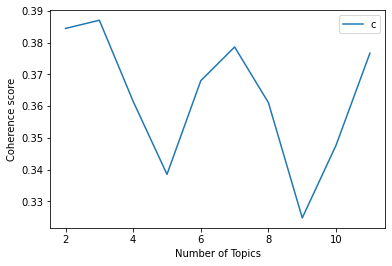

In [55]:
number_of_topics = 7
words = 10
#document_list,titles=load_data("","articles.txt")
#clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(docs_preprocessed,number_of_topics,words)



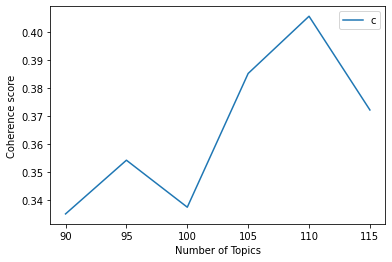

In [58]:
start,stop,step=90,120,5
plot_graph(docs_preprocessed,start,stop,step)
# 110 is optimal

In [62]:
'i' in stop_words.get_stop_words('czech')

False